In [1]:
# IMPORT AND LOAD DATA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# load merge data
DATA_DIR = Path('../data/interim')
train = pd.read_parquet(DATA_DIR / 'train_merged.parquet')

print(f'data loaded {train.shape[0]:,} row and {train.shape[1]:,} columns')

data loaded 590,540 row and 434 columns


In [11]:
train.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

## Time Features

In [2]:
# transaction time 

# constant
SECOND_PER_HOUR = 3600
SECOND_PER_DAY = 86400

# extract time features
train['hour'] = (train['TransactionDT'] // SECOND_PER_HOUR) % 24
train['day_of_week'] = (train['TransactionDT'] // SECOND_PER_DAY) % 7
train['day'] = (train['TransactionDT'] // SECOND_PER_DAY)

print('TransactionDT Statistics :')
print(f'Min : {train['TransactionDT'].min():,} second')
print(f'Max :{train['TransactionDT'].max():,} second')
print(f'Range : {train['TransactionDT'].max() // SECOND_PER_DAY } days')

print('\nExtract Features')
print(f'Hour Range {train['hour'].min()} - {train['hour'].max()}')
print(f'days in data {train['day'].nunique()}')

TransactionDT Statistics :
Min : 86,400 second
Max :15,811,131 second
Range : 182 days

Extract Features
Hour Range 0 - 23
days in data 182


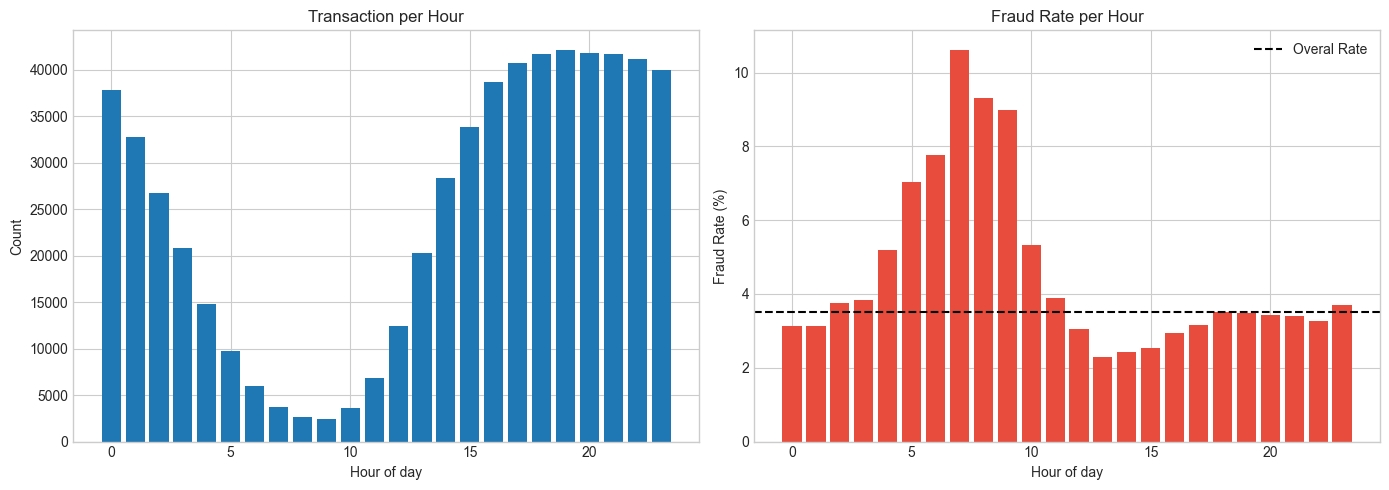

In [3]:
# Fraud by Hour

fraud_by_hour = train.groupby('hour').agg({
    'isFraud' : ['sum', 'mean', 'count']
})
fraud_by_hour.columns = ['fraud_count', 'fraud_rate', 'total_count']
fraud_by_hour['fraud_rate'] *= 100

# visualize 
fig, axes = plt.subplots(1,2, figsize=(14,5))

# transaction count/h
axes[0].bar(fraud_by_hour.index, fraud_by_hour['total_count'])
axes[0].set_title('Transaction per Hour')
axes[0].set_xlabel('Hour of day')
axes[0].set_ylabel('Count')

# fraud per rate
axes[1].bar(fraud_by_hour.index, fraud_by_hour['fraud_rate'], color='#e74c3c')
axes[1].set_title('Fraud Rate per Hour')
axes[1].set_xlabel('Hour of day')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].axhline(y=train['isFraud'].mean()*100, color='black', linestyle='--', label='Overal Rate')
axes[1].legend()

plt.tight_layout()
plt.show()


In [4]:
fraud_by_hour.columns 

Index(['fraud_count', 'fraud_rate', 'total_count'], dtype='object')

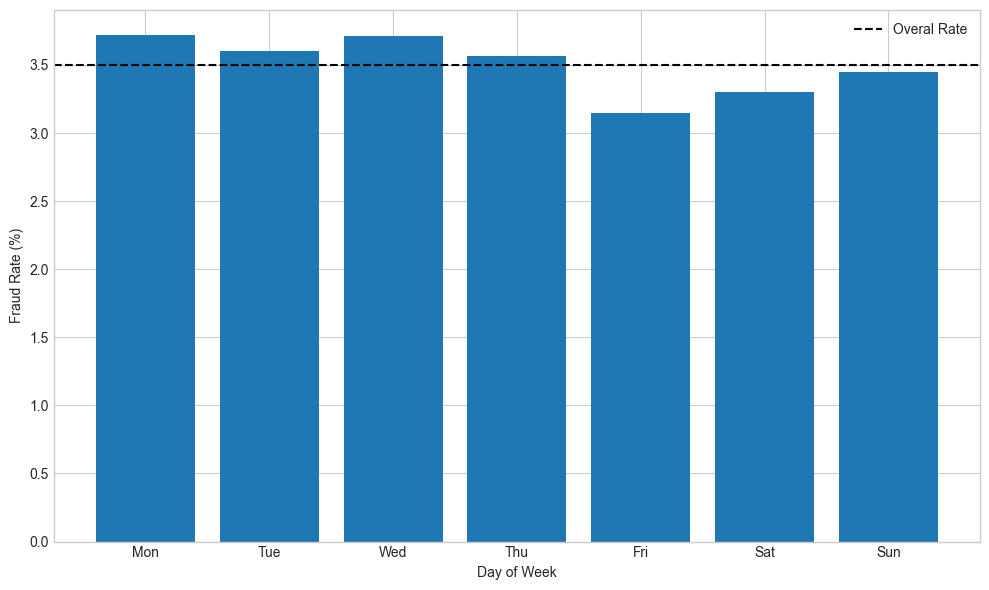

In [5]:
# fraud by day of week

fraud_by_dow = train.groupby('day_of_week')['isFraud'].mean()* 100
dow_name = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(range(7), fraud_by_dow.values)
ax.set_xticks(range(7))
ax.set_xticklabels(dow_name)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Fraud Rate (%)')
ax.axhline(y=train['isFraud'].mean()*100, color='black', linestyle='--', label='Overal Rate')
ax.legend()
plt.tight_layout()
plt.show()

## CARD FEAUTURE

In [6]:
# CARD FEATURES 

card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

for col in card_cols:
    nunique = train[col].nunique()
    missing = train[col].isnull().sum() / len(train) * 100
    dtype = train[col].dtype
    print(f'{col}: {nunique} unique, {missing:.1f}% missing, type={dtype}')

card1: 13553 unique, 0.0% missing, type=int16
card2: 500 unique, 1.5% missing, type=float32
card3: 114 unique, 0.3% missing, type=float32
card4: 4 unique, 0.3% missing, type=category
card5: 119 unique, 0.7% missing, type=float32
card6: 4 unique, 0.3% missing, type=category



card4 fraud rate :
                  fraud_rate   count
card4                               
discover            7.728161    6651
visa                3.475610  384767
mastercard          3.433095  189217
american express    2.869837    8328


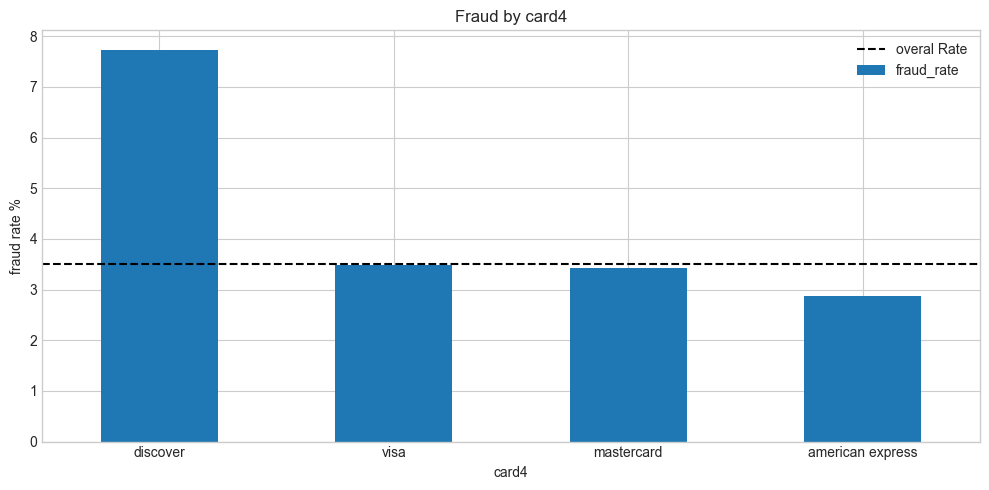


card6 fraud rate :
                 fraud_rate   count
card6                              
credit             6.678480  148986
debit              2.426251  439938
charge card        0.000000      15
debit or credit    0.000000      30


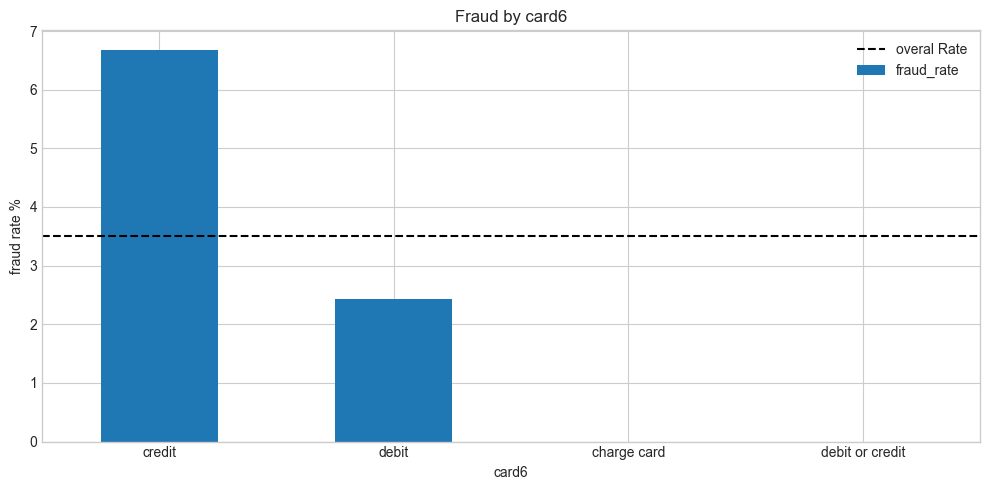

In [7]:
# fraud rate by card

# card 4 and card 6 
for col in ['card4', 'card6']:
    fraud_rate = train.groupby(col)['isFraud'].agg(['mean', 'count'])
    fraud_rate['mean'] *= 100
    fraud_rate.columns = ['fraud_rate', 'count']

    print(f'\n{col} fraud rate :')
    print(fraud_rate.sort_values('fraud_rate', ascending=False))

    # visualize
    fig, ax = plt.subplots(figsize=(10,5))
    fraud_rate['fraud_rate'].sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title(f'Fraud by {col}')
    ax.set_ylabel('fraud rate %')
    ax.axhline(y=train['isFraud'].mean()*100, color='black', linestyle='--', label='overal Rate')
    ax.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

## email feature 

In [16]:
for col in ['P_emaildomain', 'R_emaildomain']:
    top_domains = train[col].value_counts().head(10)

    print(f"\n {col} - Top 10 Domain")
    print(top_domains)

    # fraud rate by domain
    domain_fraud = train.groupby(col)['isFraud'].mean() * 100
    domain_fraud = domain_fraud.loc[top_domains.index]

    print(f'\n Fraud rate by {col} ')
    print(domain_fraud.sort_values(ascending=False))


 P_emaildomain - Top 10 Domain
P_emaildomain
gmail.com        228355
yahoo.com        100934
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
att.net            4033
Name: count, dtype: int64

 Fraud rate by P_emaildomain 
P_emaildomain
outlook.com      9.458399
hotmail.com      5.295028
gmail.com        4.354185
icloud.com       3.143450
comcast.net      3.118661
anonymous.com    2.321747
yahoo.com        2.275745
msn.com          2.199413
aol.com          2.181060
att.net          0.743863
Name: isFraud, dtype: float64

 R_emaildomain - Top 10 Domain
R_emaildomain
gmail.com        57147
hotmail.com      27509
anonymous.com    20529
yahoo.com        11842
aol.com           3701
outlook.com       2507
comcast.net       1812
yahoo.com.mx      1508
icloud.com        1398
msn.com            852
Name: count, dtype: int64

 Fraud rate by R_emaildomain 
R_emaildomain
outloo

In [19]:
# convert categorical to string for comparsion
train['email_match'] = (
    train['P_emaildomain'].astype(str) == train['R_emaildomain'].astype(str)
).fillna(False)

email_match_fraud = train.groupby('email_match')['isFraud'].mean() * 100
print(email_match_fraud)

email_match
False    2.133727
True     6.470822
Name: isFraud, dtype: float64


## count feature (c1 - c14)

In [25]:
c_cols = [f'C{i}' for i in range (1,15)]

print('Count Feature')
print(train[c_cols].describe())

Count Feature
                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569016     154.668900       0.150536      68.848457   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144575   
std        25.786976      71.508469      61.727303      95.378571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.00000

c features correaltion with is fraud :
C9    -0.031703
C5    -0.030754
C13   -0.011146
C3    -0.006833
C14    0.007921
C6     0.020909
C11    0.027484
C7     0.028160
C10    0.028396
C4     0.030382
C1     0.030570
C12    0.031905
C8     0.032139
C2     0.037229
Name: isFraud, dtype: float64


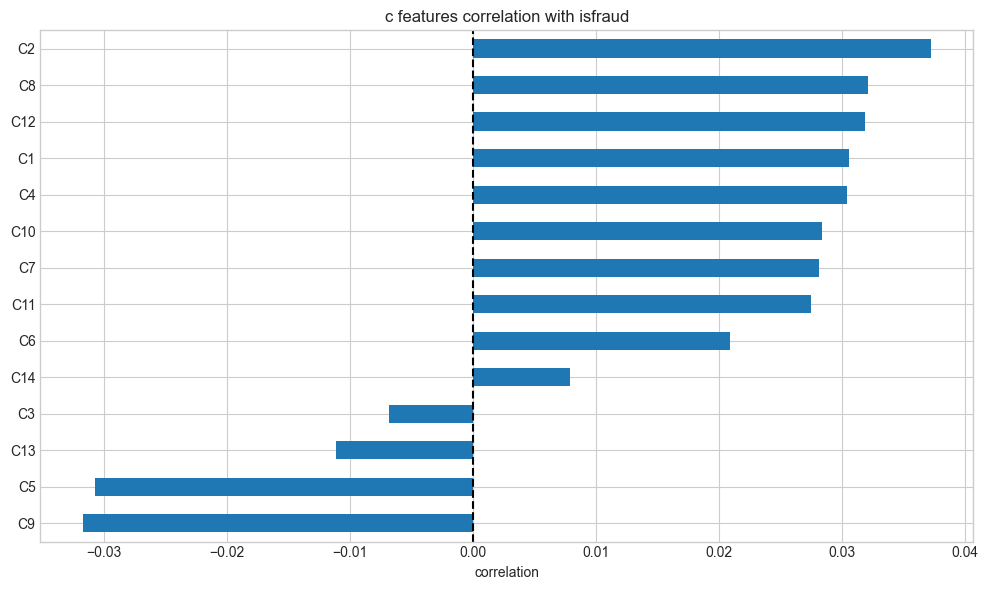

In [32]:
# correlation of c features with fraud 
c_corr = train[c_cols + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values()

print('c features correaltion with is fraud :')
print(c_corr)

# visualize
fig, ax = plt.subplots(figsize=(10,6))
c_corr.plot(kind='barh', ax=ax)
ax.set_title('c features correlation with isfraud')
ax.set_xlabel('correlation')
ax.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [44]:
#vesta features 
v_cols = [col for col in train.columns if col.startswith('V') and col[1:].isdigit()]

print(f'vesta features : {len(v_cols)} columns')

# Missing percentage
v_missing = train[v_cols].isnull().sum() / len(train) * 100

print(f'\nMissing Values in V Features:')
print(f' 0% missing: {(v_missing == 0).sum()} columns')
print(f'>0% missing: {(v_missing > 0).sum()} columns')
print(f'>50% missing: {(v_missing > 50).sum()} columns')
print(f'>90% missing: {(v_missing > 90).sum()} columns')

vesta features : 339 columns

Missing Values in V Features:
 0% missing: 0 columns
>0% missing: 339 columns
>50% missing: 159 columns
>90% missing: 0 columns


In [46]:
# top v features by corr
# calculate corr (only for col with < 50% missing )
v_cols_clean = [c for c in v_cols if v_missing[c] < 50]

v_corr = train[v_cols_clean + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values()

# top positive and negative corr
top_positive = v_corr.nlargest(10)
top_negative = v_corr.nsmallest(10)

print('top 10 positive correlation')
print(top_positive)

print('top 10 negative correlation')
print(top_negative)

top 10 positive correlation
V45    0.281832
V44    0.260376
V86    0.251828
V87    0.251737
V52    0.239469
V51    0.223191
V40    0.212442
V39    0.203097
V38    0.199005
V43    0.198274
Name: isFraud, dtype: float64
top 10 negative correlation
V48   -0.115786
V49   -0.110920
V90   -0.110168
V29   -0.107852
V91   -0.105453
V69   -0.104521
V30   -0.103088
V70   -0.100900
V35   -0.077116
V10   -0.074658
Name: isFraud, dtype: float64
